<a href="https://colab.research.google.com/github/MarcStorm/pommerman/blob/master/pommerman/MarcusMarkRunner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''Install pytorch'''

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
'''Install gym'''

!pip install gym

    100% |████████████████████████████████| 1.5MB 11.0MB/s 
    100% |████████████████████████████████| 1.0MB 13.4MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/ea/ec/dd/33bcc8801d345f0b640fced8a0864a7c8474828564bc5ccf70
Successfully built gym


In [3]:
'''Clone and install MultiAgentLearning/playground'''

import os
os.chdir('/content')

!git clone https://github.com/MultiAgentLearning/playground
os.chdir('/content/playground')
!pip install -U .

Cloning into 'playground'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1988 (delta 2), reused 14 (delta 2), pack-reused 1969
Receiving objects: 100% (1988/1988), 1.95 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (1077/1077), done.
Processing /content/playground
    100% |████████████████████████████████| 133kB 5.9MB/s 
    100% |████████████████████████████████| 31.2MB 1.3MB/s 
    100% |████████████████████████████████| 665kB 20.8MB/s 
    100% |████████████████████████████████| 81kB 23.0MB/s 
    100% |████████████████████████████████| 174kB 29.0MB/s 
    100% |████████████████████████████████| 51kB 20.4MB/s 
    100% |████████████████████████████████| 747kB 19.5MB/s 
    100% |████████████████████████████████| 92kB 27.7MB/s 
    100% |████████████████████████████████| 204kB 30.1MB/s 
    100% |████████████████████████████████| 1.2MB 15.0MB/s 
    100% |███████████████████████

In [4]:
!pip install timestamp

  Running setup.py bdist_wheel for timestamp ... - done
  Stored in directory: /root/.cache/pip/wheels/98/ce/47/81db33b7307eb75b3f752b1536d667af945059fd22e658245c
Successfully built timestamp


In [5]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import timestamp
import matplotlib.pyplot as plt
from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent, BaseAgent
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility, characters
from pommerman.constants import Action
from torch.nn.parameter import Parameter
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

Import error GL! You will not be able to render --> Library "GL" not found.


In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

# Flattens a state s on the form list<dict> where each dict contains information of a state
def flatten_state(s):
    # Usage Example:
	# def forward(self, x):
	#     x = flatten_state(x)
	# where x is np.atleast1d(S[0])
	return torch.from_numpy(np.array([flatten_state_aux(x) for x in s])).float()
	

def flatten_state_aux(s):
    # Lists
    alive = [1 if x in s['alive'] else 0 for x in range(10,14)]
    board = s['board']
    bomb_blast_strength = s['bomb_blast_strength']
    bomb_life = s['bomb_life']
    # Tuples
    position = s['position']
    # Ints
    blast_strength = s['blast_strength']
    can_kick = s['can_kick']
    ammo = s['ammo']
    # Enums
    teammate = s['teammate'] #9 for FFA
    enemies = s['enemies'] #11,12,13 for FFA and training agent id = 0
    
    a = np.append(np.array(alive),np.array(board).flatten())
    a = np.append(a,np.array(bomb_blast_strength).flatten())
    a = np.append(a,np.array(bomb_life).flatten())
    a = np.append(a,position[0])
    a = np.append(a,position[1])
    a = np.append(a,blast_strength)
    a = np.append(a,can_kick)
    a = np.append(a,ammo)
    # Commented out as we get size 376 but expected 372. I assume we calculated wrong.
    # Makes sense to ignore these imo
    #a = np.append(a,teammate.value)
    #a = np.append(a,[e.value for e in enemies])
    return a.astype(float)

In [7]:
torch.backends.cudnn.enabled

True

Actions: 
    Stop = 0,
    Up = 1,
    Down = 2,
    Left = 3,
    Right = 4,
    Bomb = 5

In [0]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = flatten_state(x)
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [0]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

In [0]:
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

In [34]:
#n_inputs = env.observation_space.shape[0]
n_inputs = 372
#n_hidden = 20
n_hidden = 500
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)



state shape: 372
action shape: 6


In [0]:
class TrainingAgent(BaseAgent):
    
    def __init__(self, character=characters.Bomber):
        super().__init__(character)
        
        
    def act(self, obs, action_space):
        return 0

In [0]:
# training settings
debug = False
num_episodes = 10

discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 5 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

if use_cuda:
    policy.cuda()


In [38]:
# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        
        # Add four random agents
        agents = []
        #for agent_id in range(4):
        #    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
        agents = {
            '0' : SimpleAgent(config["agent"](0, config["game_type"])),
            '1' : RandomAgent(config["agent"](1, config["game_type"])),
            '2' : RandomAgent(config["agent"](2, config["game_type"])),
            '3' : TrainingAgent(config["agent"](3, config["game_type"]))
        }
        env.set_agents(list(agents.values()))
        env.set_init_game_state(None)
        
        s = env.reset()
        done = False
        while(not done):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(np.atleast_1d(s[3]))
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            
            
            actions = env.act(s)
            actions[3] = a
            
            obs, reward, done, info = env.step(actions)
            
            rollout.append((s[3], a, reward[3]))
            
            s = obs
            if done: break
                
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        
        # policy gradient update
        policy.optimizer.zero_grad()
        if i < 2 and debug:
            print("torch.from_numpy(states).float()")
            print(torch.from_numpy(states).float())
            print(torch.from_numpy(states).float())
            print()
            
            print("policy(torch.from_numpy(states).float())")
            print(policy(torch.from_numpy(states).float()))
            print(policy(torch.from_numpy(states).float()).size())
            print()
            
            print("torch.from_numpy(actions))")
            print(torch.from_numpy(actions))
            print(torch.from_numpy(actions).size())
            print()
            
            print("policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions))")
            print(policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)))
            print()
            
            print("policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)")
            print(policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1))
            print()
        
        a_probs = policy([s[0] for s in states]).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                done = False
                while not done:
                    with torch.no_grad():
                        a = policy(np.atleast_1d(s[3])).float().argmax().item()
                        
                    actions = env.act(obs)
                    actions[3] = a
                    s, r, done, info = env.step(actions)
                    reward += r[3]
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training


AttributeError: ignored

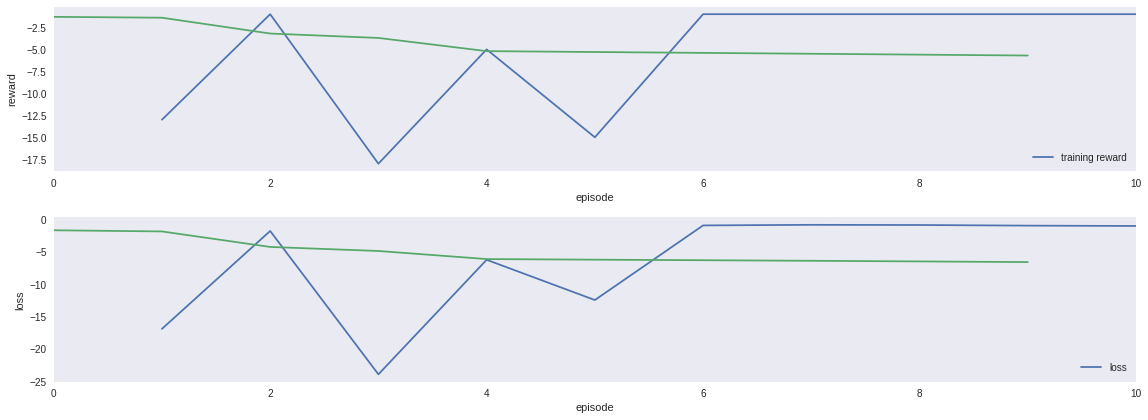

In [15]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

In [0]:
os.chdir('/content/playground')

# Create filename
#FILENAME = <Name of agent>-<timestamp>.pt

## Save file
PATH = "firstAgent.pt"
#PATH = "/home/senbyo/Documents/DTU/deepLearning/Pommerman/pommerman/resources/firstAgent.pt"
torch.save(policy.state_dict(), PATH)

In [22]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
uploaded = drive.CreateFile()
uploaded.SetContentFile('firstAgent.pt')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1XlEvxjtKDTGJe1XkYjWDg_otgqhYSSnz


In [0]:
learning_rate = 0.001 # you know this by now
n_inputs = 372
n_hidden = 500
n_outputs = 6

class FirstAgent(BaseAgent):
    
    def __init__(self, character=characters.Bomber):
        super().__init__(character)
        self.policyNet = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)
        state_list = torch.load(PATH)
        self.policyNet.load_state_dict(state_list)
        
        
    def act(self, obs, action_space):
        # Kald neuralt netværk og return
        with torch.no_grad():
            a_prob = self.policyNet(np.atleast_1d(obs))
        a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
        
        return a

In [0]:
# Add four random agents
agents = []
#for agent_id in range(4):
#    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
agents = {
    '0' : SimpleAgent(config["agent"](0, config["game_type"])),
    '1' : RandomAgent(config["agent"](1, config["game_type"])),
    '2' : RandomAgent(config["agent"](2, config["game_type"])),
    '3' : FirstAgent(config["agent"](3, config["game_type"]))
}
env.set_agents(list(agents.values()))
env.set_init_game_state(None)

In [25]:
# Seed and reset the environment
env.seed(0)
obs = env.reset()

# Run the random agents until we're done
done = False
while not done:
    env.render()
    actions = env.act(obs)
    obs, reward, done, info = env.step(actions)
env.render(close=True)
env.close()

print(info)
print (done)

NameError: ignored

In [0]:
# creating DataFrame from targets_data
#targets_df = pd.DataFrame(data=targets_data)
#targets_df.columns = ['targets']

# creating tensor from targets_df 
#torch_tensor = torch.tensor(targets_df['targets'].values)

# printing out result
#print(torch_tensor
dataFrame = pd.DataFrame(data=s)
columns = dataFrame.columns 
torchTenssor = dataFrame[columns].values

#print(dataFrame.values.ravel('C'))
#print(dataFrame.stack())
#print (torch.tensor(.columns.values))
#print (obs[3]['board'])
#print (obs[3]['bomb_blast_strength'])
#print (obs[3])